<p></p>

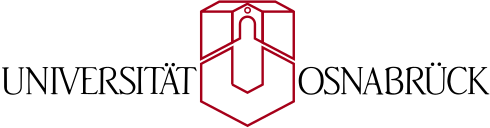
# <center>Einführung in die Künstliche Intelligenz</center> <a class="tocSkip">
### <center>Wintersemester 2020/21</center> <a class="tocSkip">
<center>Prof. Dr. Joachim Hertzberg, Felix Igelbrink, Alexander Mock</center>

# Übungsblatt 2: Informierte Suchverfahren

## Aufgabe: Suche mit negativen Pfadkosten

Nehmen Sie ein Suchproblem an, bei dem beliebig große negative Pfadkosten für einzelne Aktionen
auftreten können. Beantworten Sie die folgenden Fragen:

### 
Warum zwingt diese Möglichkeit Suchalgorithmen generell dazu, den gesamten Suchraum zu explorieren?

**Weil die Existenz einer Aktion im Suchraum, die die Pfadkosten erheblich/unendlich viel verringern kann, impliziert das eine optimale Lösung keine eindeutige Stelle im Suchraum haben wird.**

### 

Wird die Situation durch die Einführung einer negativen Schranke c verbessert, wenn gilt g(x) > c?Betrachten Sie hier sowohl Suchräume mit als auch ohne Schleifen.

**Angenommen diese negetive Schranke $c = 0$, dann:**
* **Im Fall von Schleifen würden diese als einen neuen Anfangspunkt der Suche benutzt, da negative Schleifen die Pfadkosten wieder auf** $0$ **bringen könnten** $\Rightarrow$ **Der ganze Suchraum müsste exploriert werden.**
* **Im fall von keinen Schleifen könnte eine optimale Lösung die sein, die einen Pfad der durch negative Pfadkosten eine (fast?) $0$ kostende Lösung erreicht. Diese Lösungen könnten aber vielleicht trotzdem durch einen kürzeren positiven Pfad auch gefunden werden. D.h. Die Suche nach einer optimalen Lösung ist nicht eindeutig $\Rightarrow$ Der ganze Suchraum muss exploriert werden.**

### 

Reale Probleme mit negativen Kosten lassen sich einfach konstruieren. So können beispielsweise einzelne Routenabschnitte durch besonders schöne Szenerie die Kosten für Zeit und Kraftstoff ausgleichen. Beschreiben Sie im Kontext dieses Routenplanungsproblems warum menschliche Agenten keine Endlosschleifen ausführen und erweitern Sie den Zustandsraum dahingehend, dass auch künstliche Agenten dieses Verhalten zeigen.

**Wir operieren nach einer Heuristik, mit der wir immer eine Vorstellung einer der optimalen Lösungen finden könnten bzw. wenn wir eine schon gefunden haben.**  
  
**Menschliche Agenten haben schon klare Ideen über Geschwindigkeit, Zeitwahrnehmung und Entfernung, und können damit besser schätzen, wann/wo eine optimale Lösung zu finden ist, und wie sie diese Kosten/Gewinne maximieren können bzw. wenn sie diese schon maximiert haben.**

**Künstliche Agenten können auch erweitert werden, indem man diesen eine Vorstellung einer optimalen Lösung bassierend auf den möglichen zu nehmende Entscheidungen beibringt.**

## Aufgabe: Heuristiken

Gegeben sei ein stark vereinfachter $(n \times n)$-Parkplatz mit n geparkten Fahrzeugen in der untersten Reihe. Alle Fahrzeuge sollen von der untersten in die oberste Reihe bewegt werden, allerdings in umgekehrter Reihenfolge; das Fahrzeug in Position $(i, 1)$ soll also an Position $(n − i + 1, n)$ stehen.
In jedem Zeitschritt wird jedes Fahrzeug um 1 Feld nach links, rechts, oben oder unten bewegt, oder es bleibt am aktuellen Ort stehen. Ein stehendes Fahrzeug kann von einem benachbarten Fahrzeug übersprungen werden. Zwei Fahrzeuge können nicht auf demselben Feld stehen.

### 
Geben Sie die Größe des Zustandsraums als Funktion von n an.

**Größe des Zustandraums $g(n) = {n^2 \choose n}$**

### 

Bestimmen Sie den Verzweigungsfaktor als Funktion von n.

**Verzweigungsfaktor $v(n) = 4n$**

### 
Gegeben sei ein Fahrzeug i auf dem Parkplatz an Position $(x_i, y_i)$. Geben Sie eine nichttriviale zulässige Heuristik $h_i$ an, welche die Anzahl der nötigen Züge, um das Fahrzeug zu seiner Zielposition $(n−i+1, n)$ zu bewegen, abschätzt. Es seien keine weiteren Fahrzeuge auf dem Platzplatz.

**Heuristik $=$ Manhattan Distance $\rightarrow$**
  
  $$
  h_n(x_i, y_i) = n - i + 1 - x_i + n - y_i \\
  = 2n + 1 - (x_i + y_i)
  $$

### 
Welche der folgenden Heuristiken sind zulässig, für das Problem alle n Fahrzeuge an ihre Zielposition
zu bewegen? Erklären Sie.

1. $\sum_{i=1}^n h_i$
2. $\max\{h_1, \ldots, h_n\}$
3. $\min\{h_1, \ldots, h_n\}$

1. **Zulässig, da $h_i \leq h_i^*$, sie ist Monoton, da bei jedem Nachfolgerknoten durch höchstens $(x_i + y_i)$-Schritte abnimmt.**
2. **Monoton $\Rightarrow$ Zulässig**
3. **Nicht zulässig.**

## Aufgabe: Informierte Suche im Labyrinth

Implementieren Sie die Suche im Labyrinth nun mittels informierten Suchalgorithmen. Als Heuristik verwenden Sie die Manhattan-Distanz zwischen der betrachteten Position und dem Ziel. Diese lässt sich wie folgt berechnen:

$$d(a,b) = \sum_i|a_i-b_i|$$

Als Pfadkosten können Sie konstante Kosten von 1 pro Feld annehmen.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import randint
import enum
# Try to import the numba just-in-time compiler
# This is optional and will not result in an error but will speed up the maze generation significantly!
try:
    from numba import njit
except ImportError:
    # use a dummy wrapper instead
    # this will be significantly slower
    def njit(*args, **kwargs):
        def __wrapped__(function):
            return function
        return __wrapped__   

class MazeTiles(enum.IntEnum):
    EMPTY = 0  # value of an empty tile
    WALL = 5   # value of a wall tile
    START = 1  # value of the start tile. This is only used when writing the maze to an ASCII representation.
    END = 2    # value of the goal tile. This is only used when writing the maze to an ASCII representation.
    

class Maze(object):
    """
    Class representing a Maze. By default it is randomly generated.
    """
    MAZE_DTYPE = np.int8  # data type of the maze representation
       
    # color values for the plot
    START_COLOR = 'blue'
    END_COLOR = 'red'


    def __init__(self, shape, complexity=0.75, density=0.50, seed=None, generate=True):
        """
        Initialize a maze with the given shape.
        Optionally, a maze is generated randomly using the randomized prim's algorithm
        (https://en.wikipedia.org/wiki/Maze_generation_algorithm).
        :param shape: tuple(x,y)
            The shape of the maze to create.
            Even x and y values will be increased by one so the resulting shape is always odd.
        :param complexity: float
            The complexity parameter when randomly generated (between 0.0 and 1.0).
        :param density: float
            The density of the randomly generated maze (between 0.0 and 1.0). Low values will
            result in more empty space between the walls of the maze.
        :param seed: int
            Seed to use for the random generation. By default it is initialized with the system entropy
        :param generate: bool
            Generate a random maze.
        """

        # Only odd shapes allowed
        self.shape = ((shape[0] // 2) * 2 + 1, (shape[1] // 2) * 2 + 1)
        self.board = np.zeros(self.shape, dtype=self.MAZE_DTYPE)
        # Fill borders
        self.board[0, :] = self.board[-1, :] = self.board[:, 0] = self.board[:, -1] = MazeTiles.WALL
        self.start = (1,1)
        self.end = (self.shape[0]-2, self.shape[1]-2)
        if generate:
            self._create(self.shape, complexity, density, seed)

    def to_ascii(self):
        """
        Convert the maze into an ascii representation that can be printed on the command line or stored in a file.
        :return: str
            ASCII representation of the maze.
        """
        rep = ''

        mapping = {MazeTiles.WALL: 'X',
                   MazeTiles.EMPTY: ' ',
                   MazeTiles.START: 'S',
                   MazeTiles.END: 'G'}
        board_copy = self.board.copy()
        board_copy[self.start] = MazeTiles.START
        board_copy[self.end] = MazeTiles.END
        for i in range(self.nrows):
            for j in range(self.ncolumns):
                try:
                    rep += mapping[board_copy[i, j]]
                except KeyError:
                    rep += ' '
            rep += '\n'
        return rep

    def plot(self, fig=None):
        """
        Plot the maze. This requires the matplotlib library.
        :return: matplotlib.Figure
            The figure of the plot. By default this can be ignored safely
        """
        import matplotlib.pyplot as plt
        if fig is None:
            fig = plt.figure(figsize=(10, 5))
        p = plt.imshow(self.board, cmap=plt.cm.binary, interpolation='nearest', zorder=-1)
        plt.scatter(self.start[1], self.start[0], c=self.START_COLOR, zorder=5)
        plt.scatter(self.end[1], self.end[0], c=self.END_COLOR, zorder=5)
        plt.gca().set_xticks(np.arange(-.5, self.shape[1], 1), minor=True)
        plt.gca().set_xticks(np.arange(self.shape[1], 5))
        plt.gca().set_yticks(np.arange(-.5, self.shape[0]+0.5, 1), minor=True)
        plt.gca().set_yticks(np.arange(self.shape[0], 5))
        plt.grid(which='minor')
        return fig

    def write_to_file(self, filename):
        """
        Write the maze into the given file in ASCII representation.
        :param filename: str
            The file to write
        """
        f = open(filename, 'w')
        f.write(self.to_ascii())
        f.close()

    @property
    def nrows(self):
        """
        Property to return the number of rows of the maze.
        :return: int
            number of rows.
        """
        return self.shape[0]

    @property
    def ncolumns(self):
        """
        Property to return the number of columns of the maze.
        :return: int
            number of columns.
        """
        return self.shape[1]

    def is_wall(self, x, y):
        """
        Return True if the given coordinate is a wall tile
        :param x: int
            the x coordinate
        :param y: int
            the y coordinate
        :return: bool
            True if a wall tile, False otherwise
        """
        return self.board[x, y] == MazeTiles.WALL

    def is_empty(self, x, y):
        """
        Return True if the given coordinate is an empty tile
        :param x: int
            the x coordinate
        :param y: int
            the y coordinate
        :return: bool
            True if a empty tile, False otherwise
        """
        return self.board[x, y] == MazeTiles.EMPTY

    def _get_dead_ends(self):
        """
        Internal function. DO NOT USE
        """
        from scipy.signal import convolve2d
        board = self.board
        kernel = np.ones((3,3), dtype=self.MAZE_DTYPE)
        kernel[1,1] = 0

        indices = np.where(np.logical_and(board == 0, convolve2d(board, kernel, fillvalue=1, mode='same') == 7))
        return indices

    def set_start_end_random(self):
        """
        Set the start and end of the maze to random locations.
        Both coordinates will always be placed in dead ends of the maze.
        :return: tuple(start, end)
            The start and end location
        """
        dead_ends = self._get_dead_ends()
        indices = np.arange(0, dead_ends[0].shape[0])
        indices = np.random.choice(indices, 2)
        self.start = (dead_ends[0][indices[0]], dead_ends[1][indices[0]])
        self.end = (dead_ends[0][indices[1]], dead_ends[1][indices[1]])

        return self.start, self.end

    def set_start_end(self, start, end):
        """
        Set the start and end of the maze to specifiy values.
        Note, that this does not take the existing walls into account.
        :param start: tuple(x,y)
            The start coordinate
        :param end: tuple(x,y)
            The end coordinate
        """
        self.start = tuple(start)
        self.end = tuple(end)

    def get_neighbors(self, coord, visited=set()):
        """
        Get all neighbors of a given coordinate. The order will be always left, right, up, down.
        :param coord: tuple(x,y)
            The coordinate as tuple of x and y
        :param visited: set 
            Optional visited set to exclude neighbors that have already been visited
        :return: list(tuple)
            List of all neighbors as (x,y) tuples
        """
        neighbors = [(coord[0] - 1, coord[1]), (coord[0] + 1, coord[1]), (coord[0], coord[1] - 1),
                    (coord[0], coord[1] + 1)]
        return [c for c in neighbors if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited]

    def get_neighbors_iter(self, coord, visited=set()):
        c = (coord[0], coord[1] + 1)
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c
        c = (coord[0], coord[1] - 1)
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c
        c = (coord[0] + 1, coord[1])
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c
        c = (coord[0] - 1, coord[1])
        if self.board[c[0], c[1]] != MazeTiles.WALL and c not in visited:
            yield c

    @classmethod
    def load_from_file(cls, filename):
        """
        Load a new maze from a file.
        :param filename: str
            The file to load
        :return: Maze
            New maze loaded from file
        """
        with open(filename, 'r') as f:
            content = f.readlines()

        # remove whitespace characters like `\n` at the end of each line
        content = [x.strip() for x in content]

        inverse_mapping = {'X': MazeTiles.WALL,
                           ' ': MazeTiles.EMPTY}
        xss = []
        start = None
        end = None
        for i, line in enumerate(content):
            xs = []
            for j, c in enumerate(line):
                try:
                    xs.append(inverse_mapping[c])
                except KeyError as e:
                    xs.append(MazeTiles.EMPTY)
                    if c == 'S':
                        start = (i, j)
                    elif c == 'G':
                        end = (i, j)
                    else:
                        raise e

            xss.append(xs)

        if (start is None) ^ (end is None):
            raise ArithmeticError("Either start or end not defined")

        maze = Maze((len(xss), len(xss[0])), generate=False)
        if start is not None:
            maze.set_start_end(start, end)
        for xs in xss:
            assert len(xs) == maze.ncolumns

        maze.board = np.asarray(xss)
        return maze

    def _create(self, shape, complexity=0.75, density=0.50, seed=None):
        """
        Build a maze using given complexity and density. INTERNAL FUNCTION, DO NOT USE!
        For parameters see the constructor.
        """
        if seed is not None:
            np.random.seed(seed)

        # Only odd shapes
        shape = ((shape[0] // 2) * 2 + 1, (shape[1] // 2) * 2 + 1)

        # Adjust complexity and density relatively to maze size
        n_complexity = int(complexity * (shape[0] + shape[1]))
        n_density = int(density * (shape[0] * shape[1]))

        # reinit actual maze
        self.board = np.zeros(shape, dtype=self.MAZE_DTYPE)
        Z = self.board

        # Fill borders
        Z[0, :] = Z[-1, :] = Z[:, 0] = Z[:, -1] = MazeTiles.WALL

        # Islands starting point with a bias in favor of border
        P = np.random.normal(0, 0.5, (n_density, 2))
        P = 0.5 - np.maximum(-0.5, np.minimum(P, +0.5))
        P = (P * [shape[1], shape[0]]).astype(int)
        P = 2 * (P // 2)

        WALL = MazeTiles.WALL
        EMPTY = MazeTiles.EMPTY

        @njit()
        def create_islands(Z, P,  n_density, n_complexity):
            if seed is not None:

                np.random.seed(seed)
            # Create islands
            for i in range(n_density):

                # Test for early stop: if all starting point are busy, this means we
                # won't be able to connect any island, so we stop.
                T = Z[2:-2:2, 2:-2:2]
                if T.sum() == T.size:
                    break

                x, y = P[i]
                Z[y, x] = WALL
                for j in range(n_complexity):
                    neighbours = []
                    if x > 1:
                        neighbours.append([(y, x - 1), (y, x - 2)])
                    if x < shape[1] - 2:
                        neighbours.append([(y, x + 1), (y, x + 2)])
                    if y > 1:
                        neighbours.append([(y - 1, x), (y - 2, x)])
                    if y < shape[0] - 2:
                        neighbours.append([(y + 1, x), (y + 2, x)])
                    if len(neighbours):
                        choice = np.random.randint(len(neighbours))
                        next_1, next_2 = neighbours[choice]
                        if Z[next_2] == EMPTY:
                            Z[next_1] = Z[next_2] = WALL
                            y, x = next_2
                    else:
                        break

        create_islands(Z, P, n_density, n_complexity)
        return Z

In [2]:
m = Maze((30,30))
fig = m.plot()
plt.show()

<IPython.core.display.Javascript object>

### 

Implementieren Sie den Algorithmus der Bestensuche für das gegebene Problem. Ermitteln Sie für die gegebenen Beispiele erneut:

- Laufzeit
- Anzahl der expandierten Knoten
- Maximale Tiefe des Suchbaums
- Maximale Größe der Suchfront
- Länge der gefundenen Lösung

Stellen Sie den ermittelten Pfad sowie alle vom Algorithmus besuchten Felder des Labyrinths grafisch
dar.

In [4]:
import time


def manhattan_d(a: (int, int), b: (int, int)) -> int:
    """
    Measure the distance between two points a and b

    Args:
        a (int, int) : coordinates of the first point
        b (int, int) : coordinates of the second point
    Returns:
        (int) distance between both points
    """
    x = a[0] - b[0]
    if x < 0:
        x = -x
    y = a[1] - b[1]
    if y < 0:
        y = -y
    return x + y


def sort_distances(coords: list, goal: (int, int)) -> list:
    """
    Sort a list of coordinates based on their individual distances to a goal.
    (closest-farthest)

    Args:
        coords (list): list of coordinates that are to be sorted.
        goal ((int, int)): the coordinates of the goal that are to be sorted
            against
    Returns:
        (list) the sorted coordinates
    """
    distances = []
    for i in coords:
        distances.append(manhattan_d(i, goal))
    coords, distances = zip(*sorted(zip(coords, distances)))
    return list(coords)


def best_first_search(maze: Maze, start, goal, plot=False):
    """
    Implementation of the best first search.

    Returns:
        list: the path from the start to the goal
        (int, int, int): a tuple composed of (in this order):
            * amount of expanded nodes,
            * maximal depth of the search tree, and
            * maximal size of the search front.
    """
    stopwatch = time.time()
    node_tree = [[start]]
    visited = [start]
    path: list = []
    expanded_nodes = 0
    max_front_size = 0
    while any(node_tree):
        chosen_depth = 0
        # Sort the distances on the expanded tree
        node_tree = list(sort_distances(x, goal) for x in node_tree)
        # Get the closest of all nodes with respect to the goal
        for i, level in enumerate(node_tree):
            if level[0] < node_tree[chosen_depth][0]:
                chosen_depth = i
        path.append(node_tree[chosen_depth][0])
        node_tree[chosen_depth] = node_tree[chosen_depth][1:]
        if path[-1] == goal:
            path = np.array(path).T
            return path, (
                time.time() - stopwatch,
                expanded_nodes,
                len(node_tree),
                max_front_size
            )
        neighbors = maze.get_neighbors(path[-1], set(visited))
        visited += neighbors
        node_tree[chosen_depth + 1] += neighbors
        actual_front = 0
        for i in node_tree:
            actual_front += len(i)
        max_front_size = (
            max_front_size if max_front_size > actual_front else actual_front
        )
        expanded_nodes += 1

### 
Erweitern Sie den Algorithmus aus Aufgabenteil a) nun zu einer vollständigen A*-Suche. Vergleichen Sie die erhaltenen Werte mit denen der Bestensuche sowie den uninformierten Verfahren aus Teil 1.

In [ ]:
def astar(maze, start, goal, plot=False):
    path = []
    stats = ()
    #TODO: INSERT YOUR CODE HERE
    
    return path, stats

In [ ]:
#TODO: INSERT YOUR CODE HERE


## A*-Routenplanung
In dieser Aufgabe werden Sie Ihren A*-Algorithmus auf den Daten des [OpenStreetMap-Projektes](https://www.openstreetmap.de) anwenden. Dazu werden wir das Python-Paket `osmnx` verwenden, welches Sie mit den  Aufrufen

```bash
conda config --prepend channels conda-forge
conda config --set channel_priority strict
conda install osmnx
```

in Ihrer Anaconda-Umgebnung installieren können. Das Paket stellt Funktionen zur Verfügung um die Daten von OpenStreetMap als Graph herunterzuladen und auf ihnen zu arbeiten. Die Dokumentation finden Sie [hier](https://osmnx.readthedocs.io/en/stable/). 
Für die unterliegende Graphenrepräsentation wird dabei das Paket `networkx` verwendet dessen Dokumentation Sie [hier](https://networkx.github.io) finden. Nutzen Sie die Dokumentationen um sich mit beiden Paketen vertraut zu machen. 

Sie werden primär die Straßennetze von `osmnx` nutzen. Im Folgenden finden Sie eine Vorlage für die Generierung und Nutzung eines solchen Netzes. Bei der Ausführung wird ein Straßennetz der Stadt Osnabrück geladen und eine einfache Routenplanung mit dem Dijkstra-Algorithmus durchgeführt.

*Hinweis*: Das Laden und Erzeugen der Straßennetze kann, abhängig von der Größe des gewünschten Gebietes, große Mengen an Arbeitsspeicher und Zeit beanspruchen. Daher ist im Ordner `osm_data` bereits das Straßennetz der Umgebung von Osnabrück bereitgestellt.

In [ ]:
import matplotlib
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

def node_distance(graph, node1, node2):
    """
    Return the distance between the two graph nodes in meters.
    :param graph: networkx.Graph 
        The graph to look up the nodes
    :param node1: int
        The node id of the first node
    :param node2: int
        The node id of the second node
    :return: float
        Distance between the two node in meters
    """
    return ox.distance.great_circle_vec(graph.nodes[node1]['x'], 
                                 graph.nodes[node1]['y'],
                                 graph.nodes[node2]['x'],
                                 graph.nodes[node1]['y'])

In [ ]:
# configure osmnx to cache the queries and log what it does (lots of text!)
ox.config(use_cache=True, 
          log_console=True)

# use data from file?
load_from_file = False

# positions of some locations
wachsbleiche = (52.2852171, 8.0365810704887)
goal = (52.272235, 8.060066)

# load some data
if load_from_file:
    try:
        G = ox.load_graphml('osnabrueck.graphml', folder='osm_data')
    except FileNotFoundError as e:
        raise FileNotFoundError("Graphml file 'osnabrueck.graphml' not found")
else:
    # fetch it from the osm servers
    G = ox.graph_from_point(wachsbleiche, dist=5000, network_type='drive', simplify=True)
    
wachsbleiche_node = ox.get_nearest_node(G, wachsbleiche)
goal_node = ox.get_nearest_node(G, goal)


# print the node data for the start
print("start node data:", G.nodes[wachsbleiche_node])

# print the distance between start and goal
print("distance between start and goal:", node_distance(G, wachsbleiche_node, goal_node))

# print the edge data for all edges at the starting node
print("edges around the start:")
for s, e, data in G.edges(wachsbleiche_node, data=True):
    print("\t", data)
    

In [ ]:
# use the notebook mode
%matplotlib notebook
# get a route (dijkstra; not the best!!!)
route = nx.shortest_path(G, wachsbleiche_node, goal_node)

if route:
    fig, ax = ox.plot_graph_route(G, route, figsize=(8, 8), show=False, close=False, node_color='#66ccff')
else:
    # plot just the graph
    fig, ax = ox.plot_graph(G, figsize=(8, 8), show=False, close=False, annotate=False)
    
# plot start and end positions of the route (reverse, because the coordinates are returned in the wrong order for matplotlib!)
ax.scatter(*reversed(wachsbleiche), c='r', s=15, zorder=3)
ax.scatter(*reversed(goal), c='g', s=15, zorder=3)

plt.show()


In [ ]:
# print route information
print("route nodes:")
for i in range(len(route)-1):
    print("\t", G.get_edge_data(route[i], route[i+1]))

### 
Implementieren Sie einen A*-Algorithmus zur Routenplanung zwischen zwei Adressen in Ihrem Straßennetz. Als Heuristik verwenden Sie die (euklidische) Luftliniendistanz zwischen dem betrachteten Knoten und dem Ziel. Nehmen Sie zunächst die Länge der ausgewählten Kante im Graphen als Pfadkosten an. Die Länge finden Sie in den Metadaten der entsprechenden Kante.

*Hinweis*: Das Paket `networkx` stellt bereits eine Grundimplementation des A*-Algorithmus bereit. Sie können diese verwenden um die Funktionalität Ihrer eigenen Implementation zu verifizieren.

In [ ]:
#TODO: INSERT YOUR CODE HERE


### 
Erweitern Sie Ihren Algorithmus um weitere Informationen über die befahrenen Wege zu nutzen. Möglichkeiten sind hier beispielsweise die Bevorzugung möglichst schneller Wege oder die Bevorzugung bestimmter Straßentypen. Vergleichen Sie die Ergebnisse mit dem vorherigen Aufgabenteil.

In [ ]:
#TODO: INSERT YOUR CODE HERE
